In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
site_key = 'Carp'
freq_key = 'LF'

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '20of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)

In [5]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
single_night_files = files_from_loc[:21]

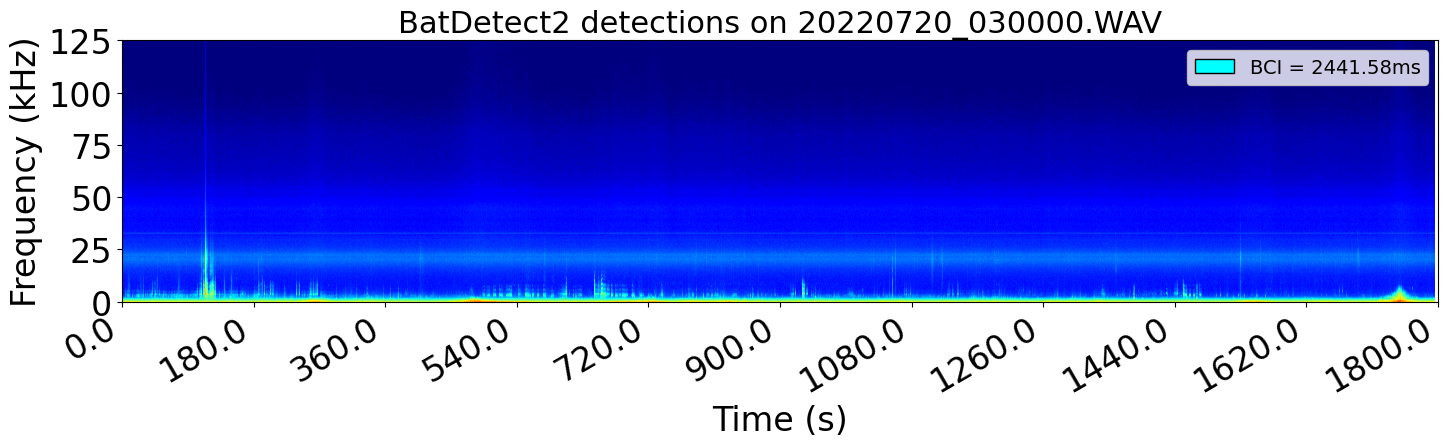

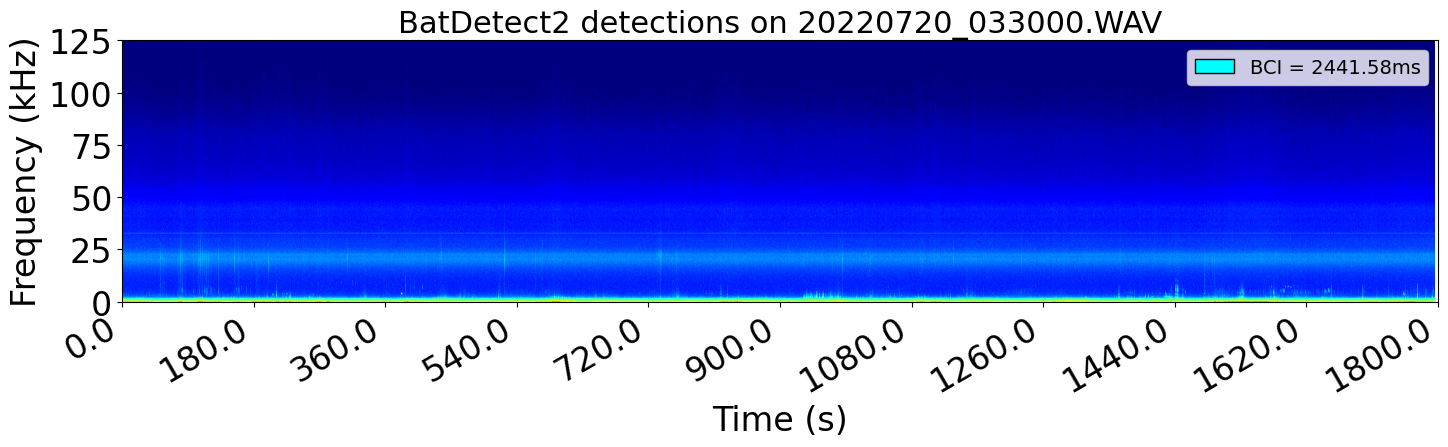

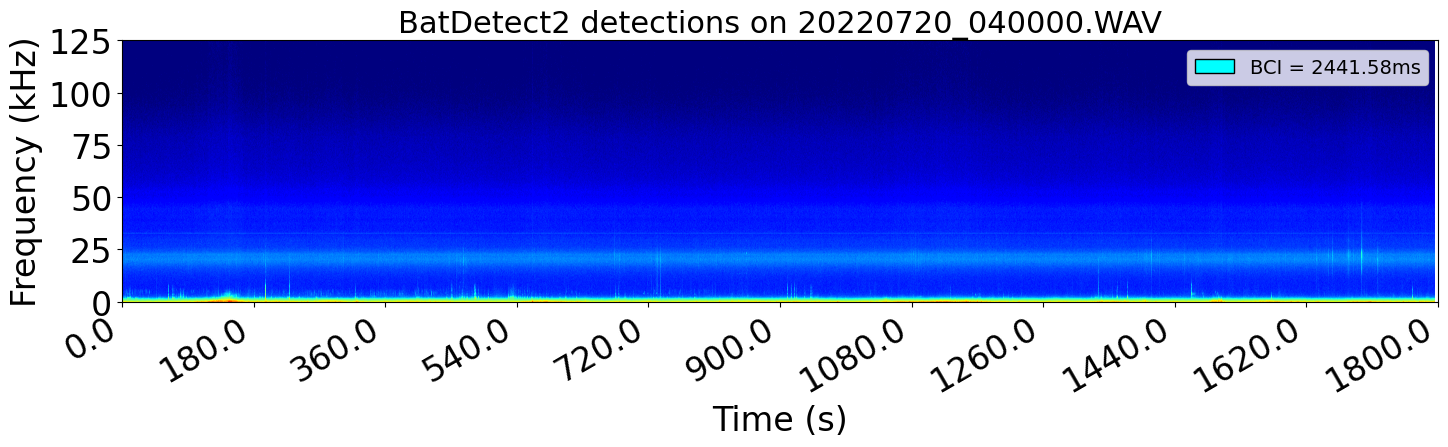

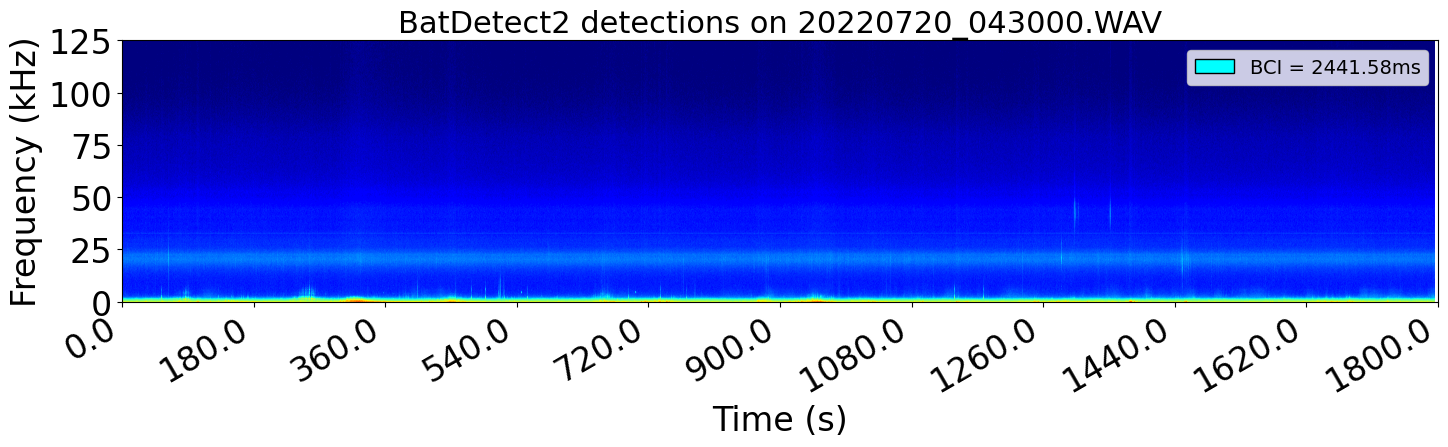

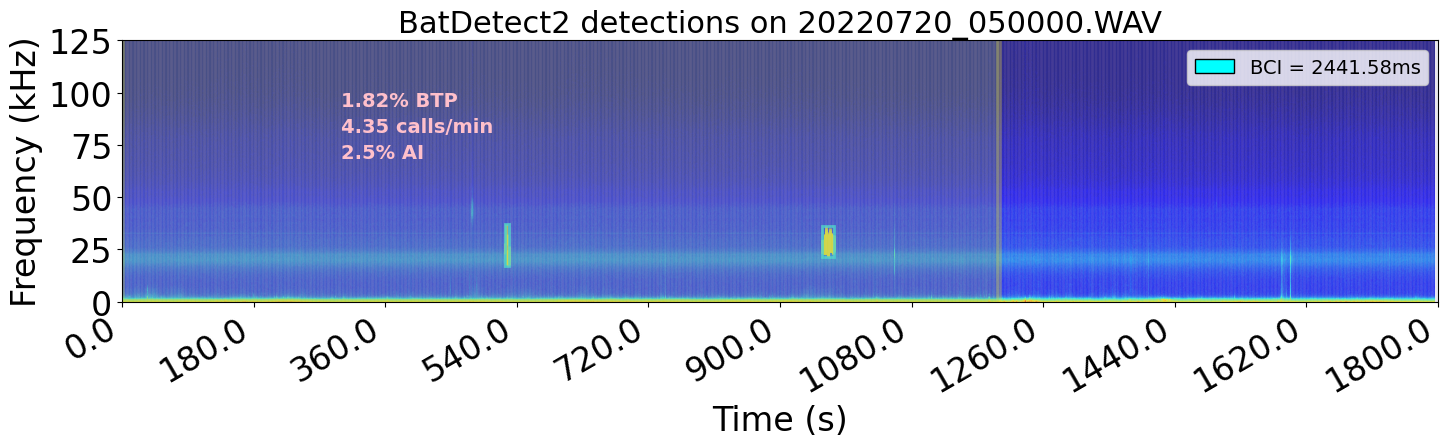

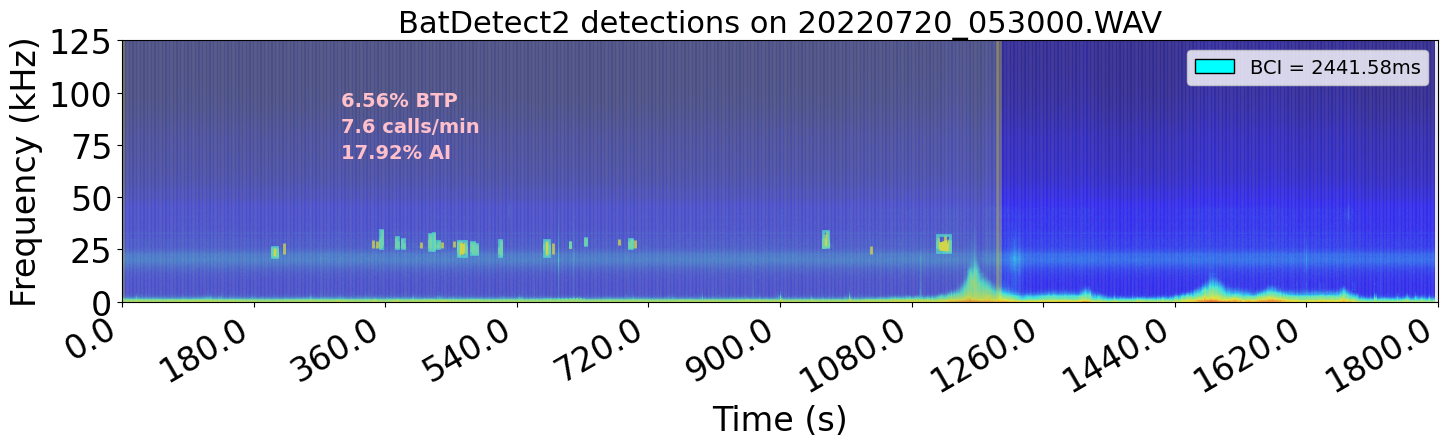

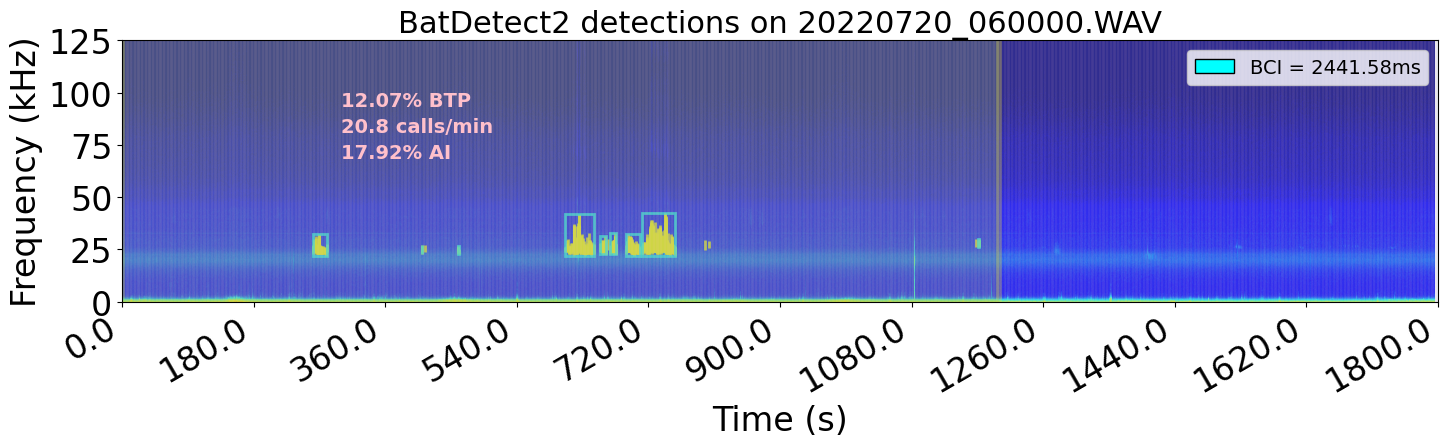

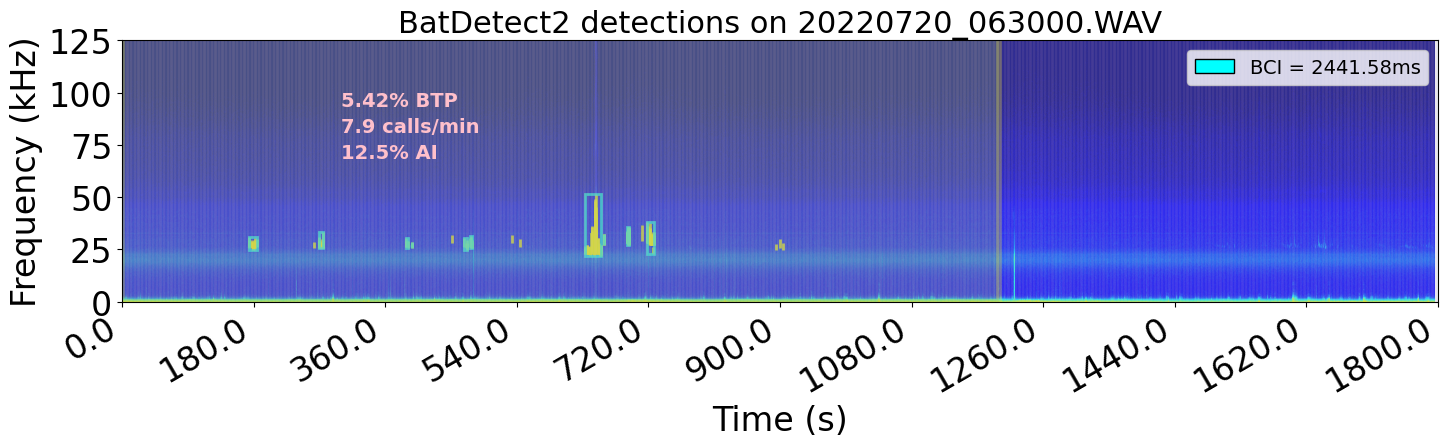

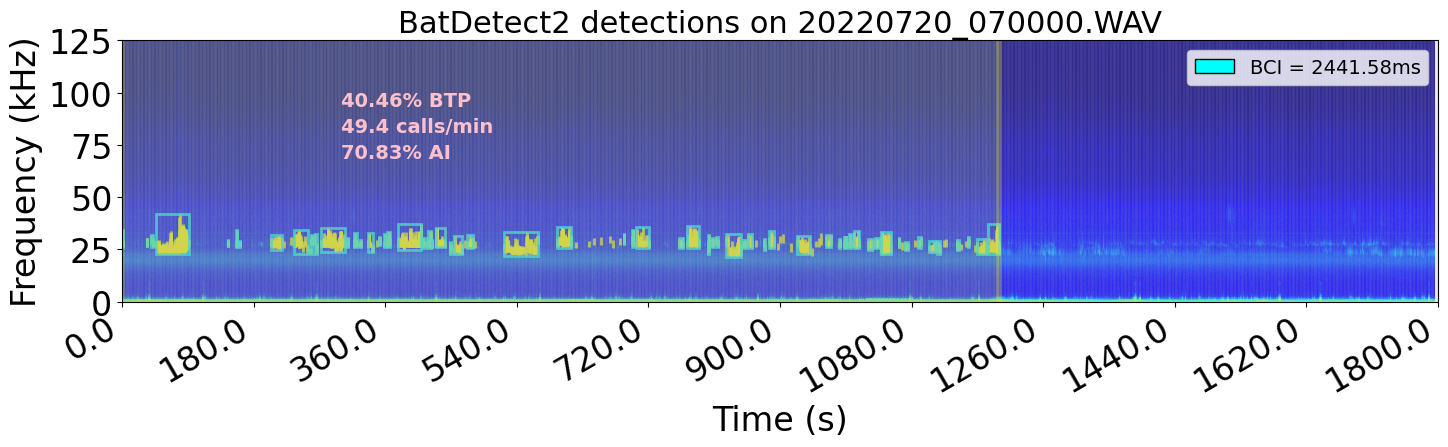

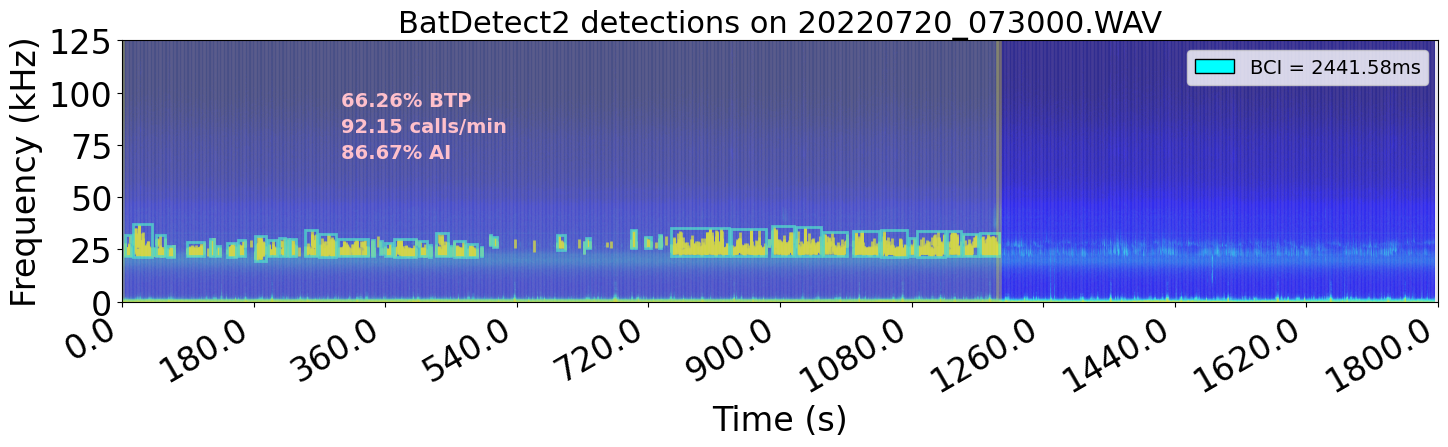

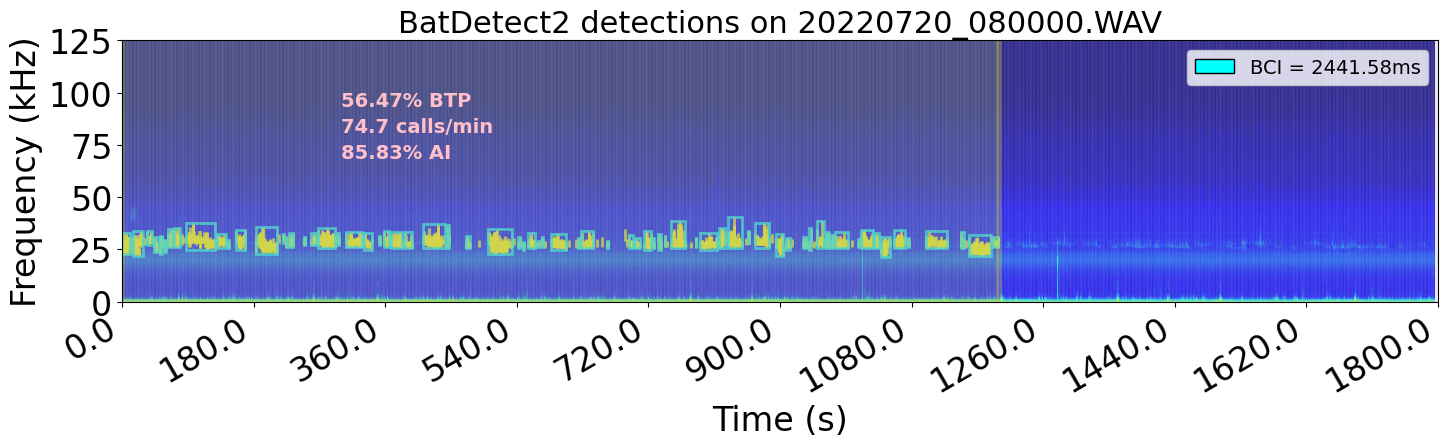

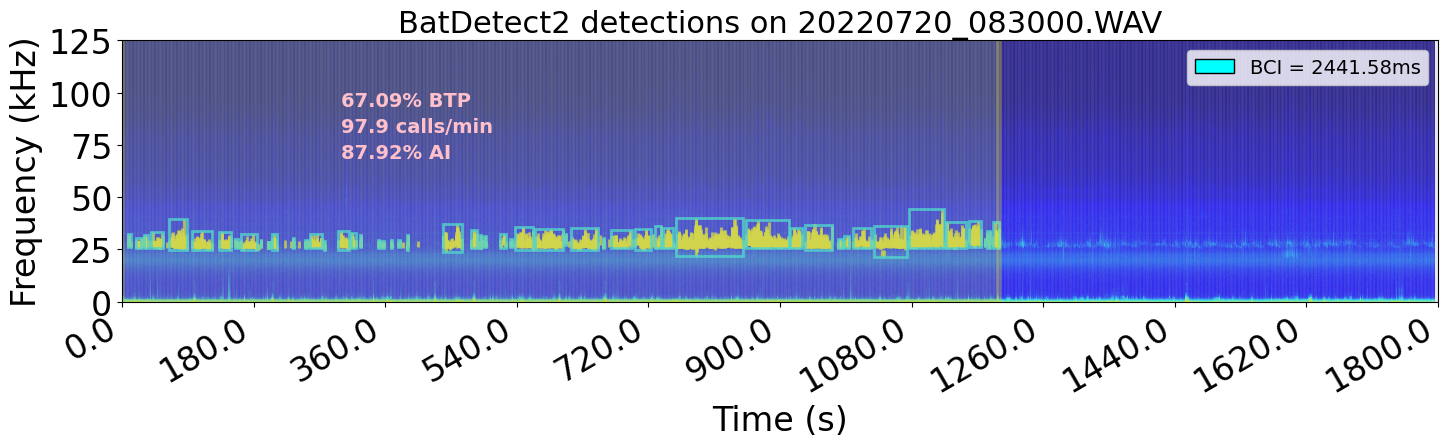

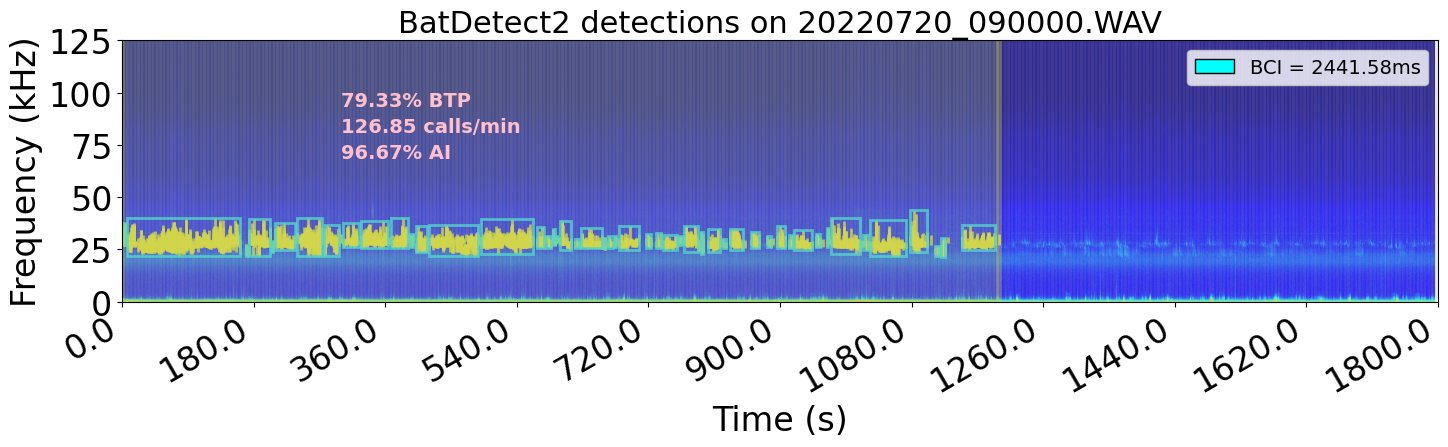

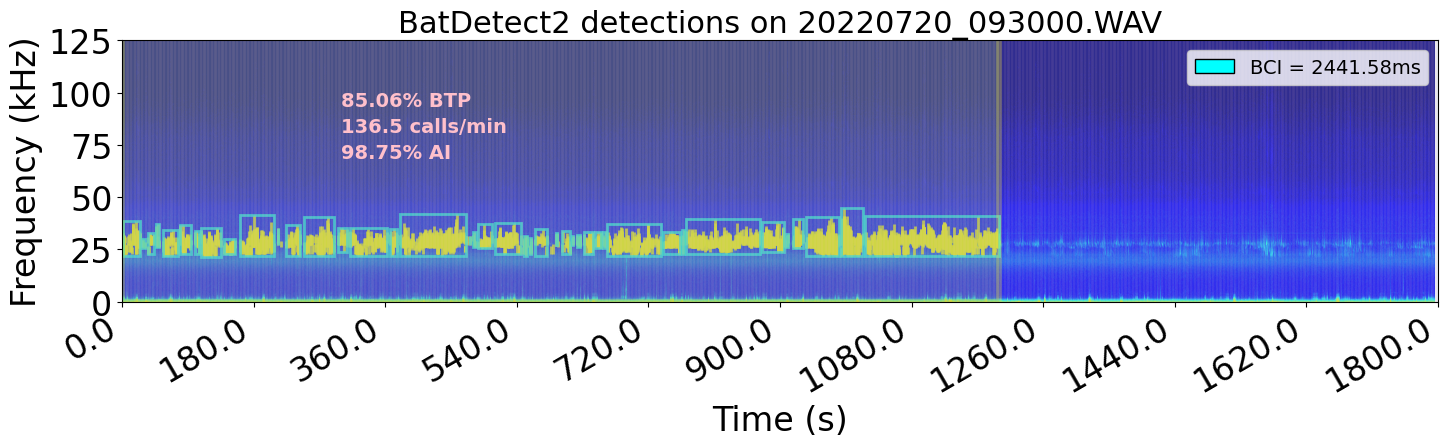

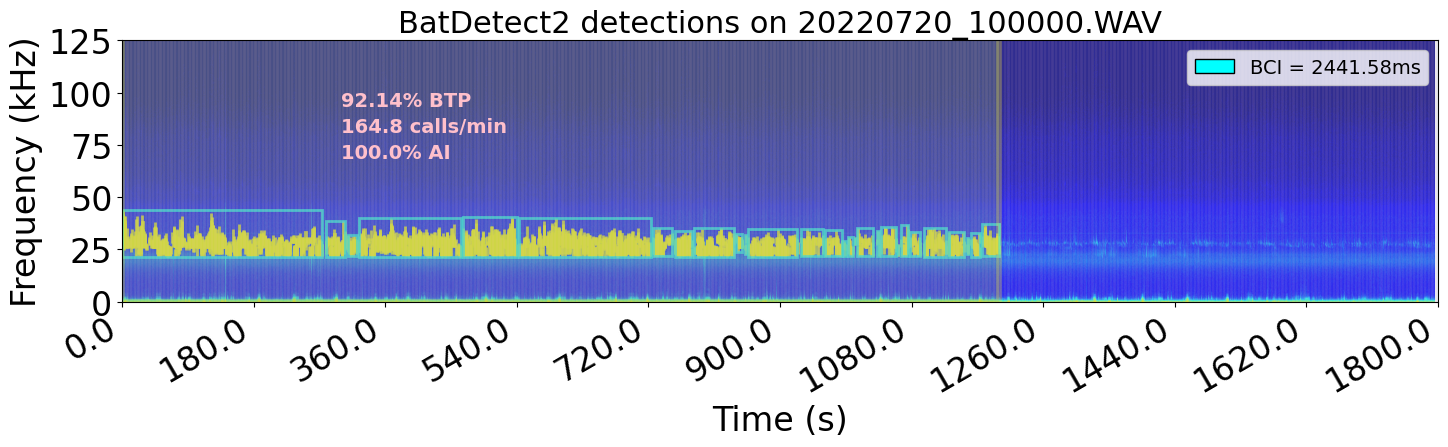

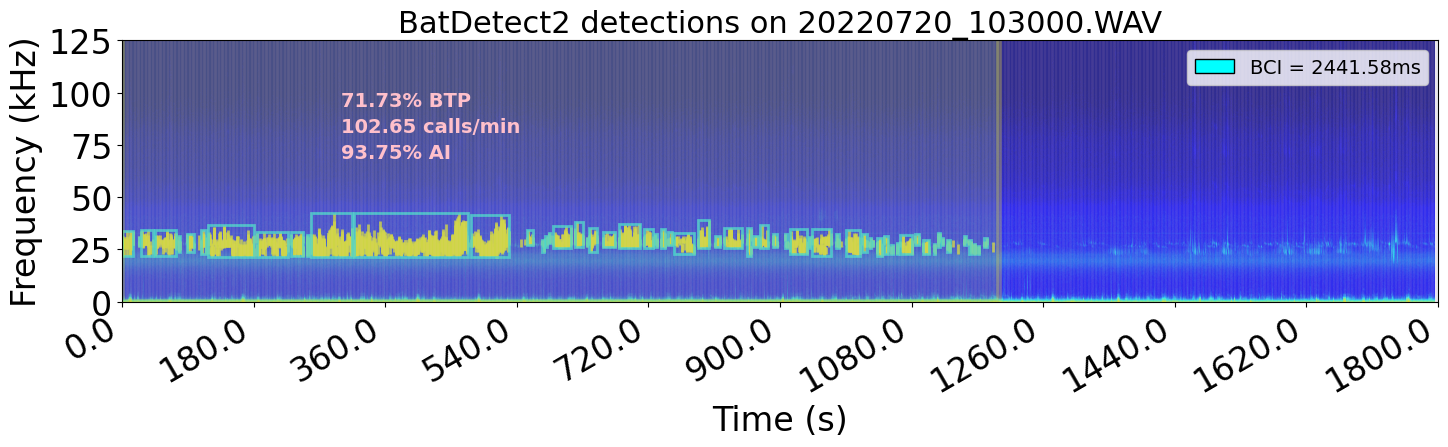

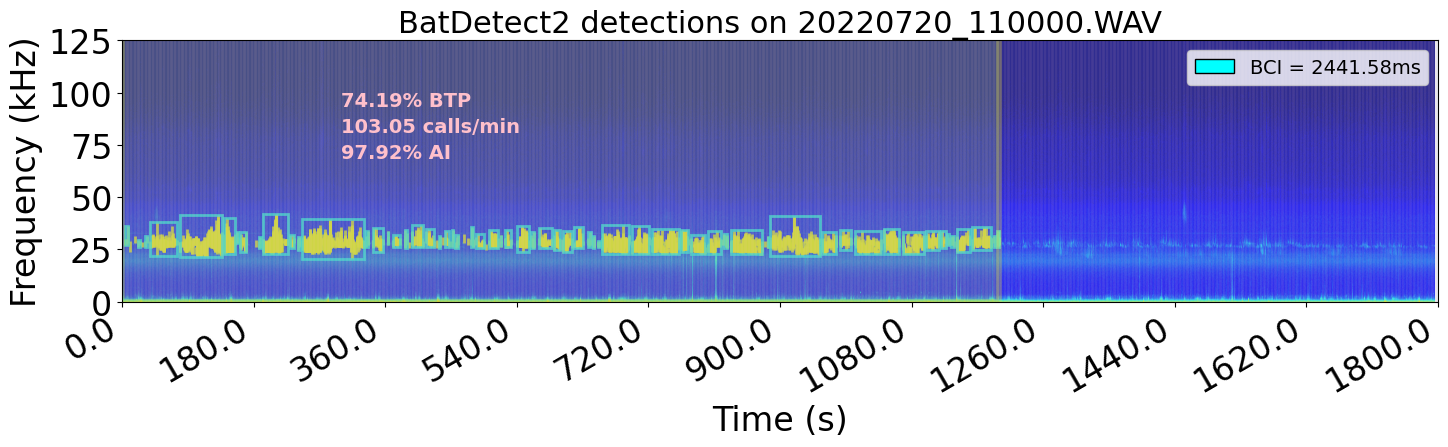

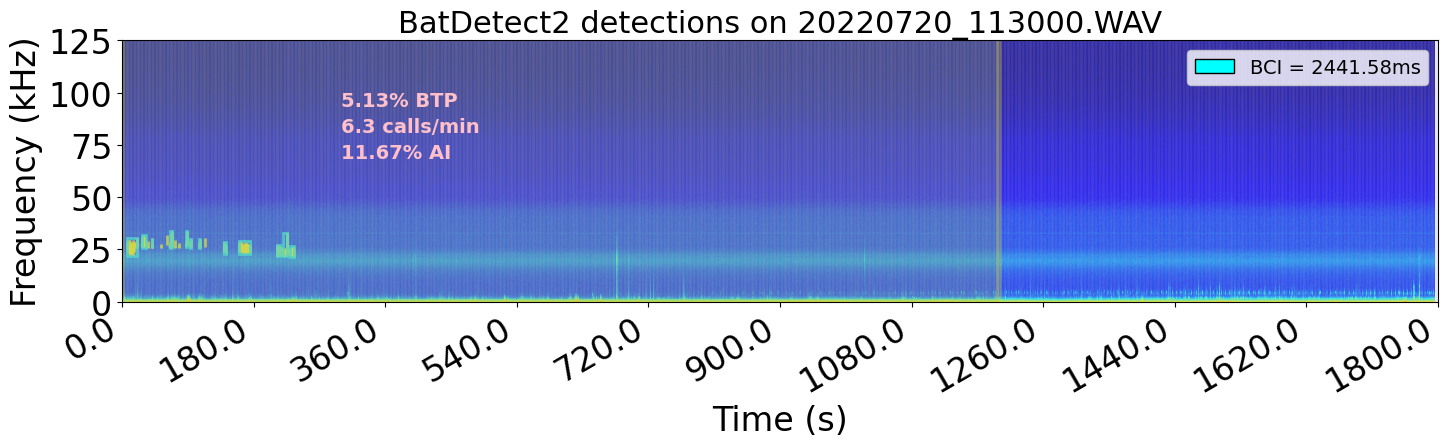

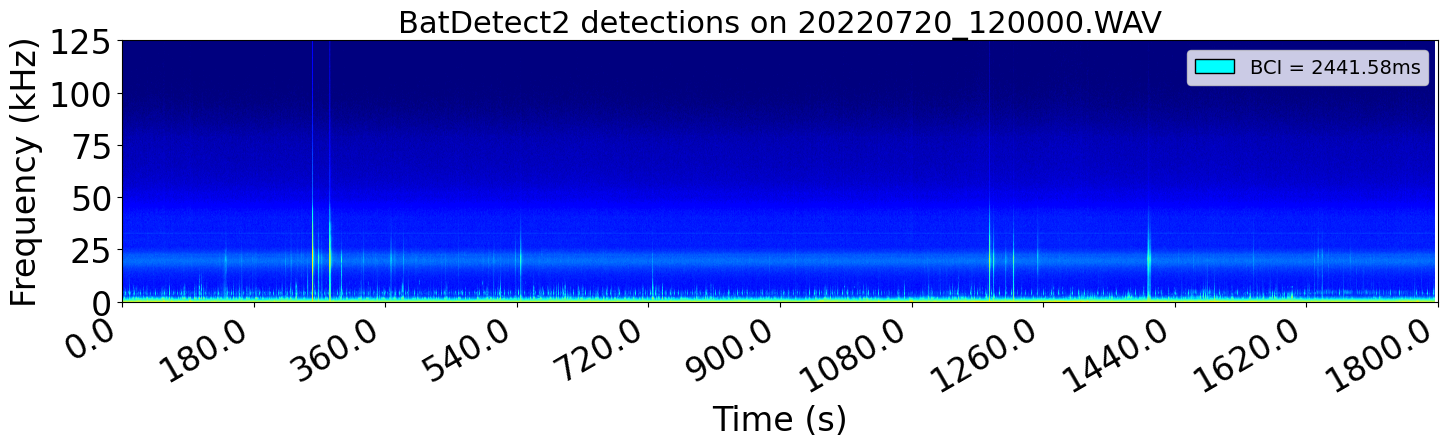

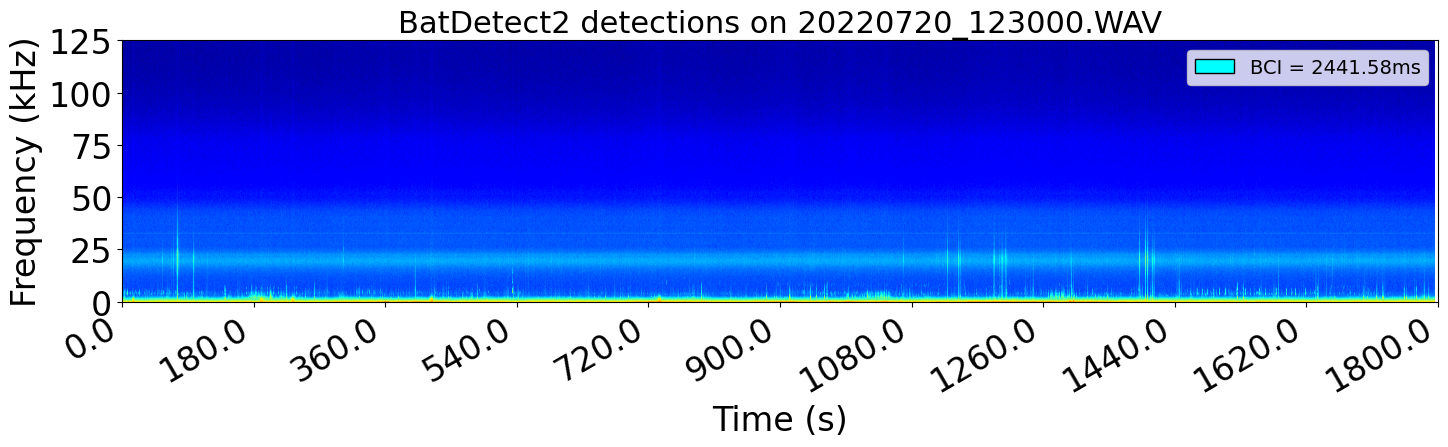

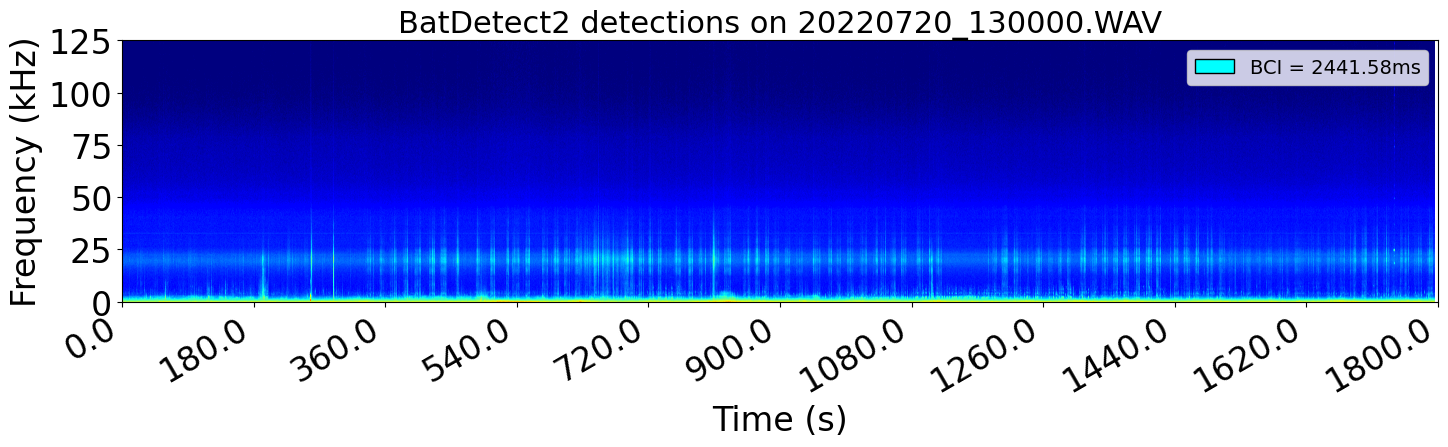

In [6]:
for file in single_night_files:
    file_path = Path(file)
    filename = file_path.name
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    start = 0
    duration = 1800
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = 1024
    spec_features['cmap'] = 'jet'

    file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
    file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

    plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
    plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]
    if not(plot_dets.empty):
        bout_metrics = bt.generate_bout_metrics_for_location_and_freq(plot_dets, data_params, bout_params)
        plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] >= start, bout_metrics['end_time'] <= (start+duration))]
    else:
        plot_bouts = pd.DataFrame()
    # bt_plt.plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)
    bt_plt.plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)